In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [6]:
!pip install pandas

  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)


In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Dropout, GlobalAveragePooling2D, MaxPooling2D, Flatten, Conv2D, BatchNormalization, Activation
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install speedtest-cli
# !speedtest-cli


In [ ]:
# !unzip ./face_populer.zip 


In [4]:
dataset_test = './data_populer/test'
dataset_train = './data_populer/train'

In [18]:
image_size = (48, 48)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=dataset_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'grayscale',
    subset="training",

)

validation_generator = train_datagen.flow_from_directory(
    directory=dataset_test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'grayscale',
    subset="validation",
)

# Mengecek label
labels = train_generator.class_indices
print(labels)

# Total gambar
total_train_images = train_generator.samples
total_val_images = validation_generator.samples
total_images = total_train_images + total_val_images

print("Total training images:", total_train_images)
print("Total validation images:", total_val_images)
print("Total images in dataset:", total_images)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Total training images: 22968
Total validation images: 1432
Total images in dataset: 24400


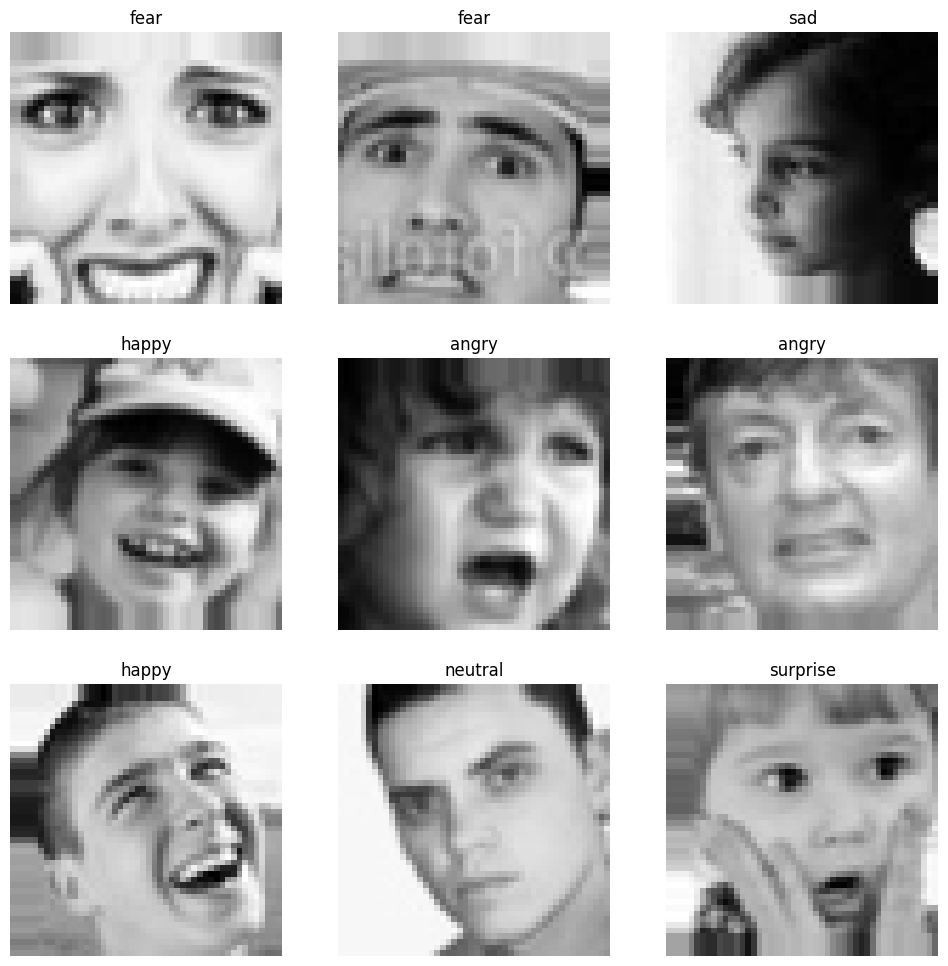

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Mengambil satu batch dari generator
images, labels = train_generator.next()

# Menghitung jumlah gambar yang akan ditampilkan
num_images = 9  # Anda dapat mengubah ini sesuai kebutuhan

# Membuat plot untuk menampilkan gambar
plt.figure(figsize=(12, 12))

# Mendapatkan class indices dari generator
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

for i in range(num_images):
    # Mengambil gambar dan label
    ax = plt.subplot(3, 3, i + 1)
    
    # Mengambil gambar dan melakukan transpose
    image = images[i]
    image = np.clip(image, 0, 1)  # Pastikan gambar berada dalam rentang [0, 1]
    
    # Menampilkan gambar
    plt.imshow(image.squeeze(), cmap='gray')  # Jika grayscale, gunakan cmap='gray'
    
    # Menentukan label
    label_index = np.argmax(labels[i])  # Mengambil index label dari prediksi one-hot
    label_name = class_labels[label_index]  # Mengambil nama label sesuai index
    
    # Menambahkan judul
    plt.title(label_name)
    plt.axis("off")

plt.show()


In [19]:
model= tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/30
359/359 [==============================] - 426s 1s/step - loss: 2.0622 - accuracy: 0.2318 - val_loss: 2.3235 - val_accuracy: 0.2472 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - 44s 121ms/step - loss: 1.6742 - accuracy: 0.3587 - val_loss: 2.0461 - val_accuracy: 0.3038 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - 48s 132ms/step - loss: 1.4445 - accuracy: 0.4428 - val_loss: 1.2737 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 4/30
359/359 [==============================] - 44s 122ms/step - loss: 1.3055 - accuracy: 0.5023 - val_loss: 1.5911 - val_accuracy: 0.4302 - lr: 0.0010
Epoch 5/30
359/359 [==============================] - 45s 125ms/step - loss: 1.2386 - accuracy: 0.5277 - val_loss: 1.1799 - val_accuracy: 0.5622 - lr: 0.0010
Epoch 6/30
359/359 [==============================] - 43s 120ms/step - loss: 1.1943 - accuracy: 0.5472 - val_loss: 1.1567 - val_accuracy: 0.5754 - lr: 0.0010
Epoch 7/30
359/359 [==============================] - 

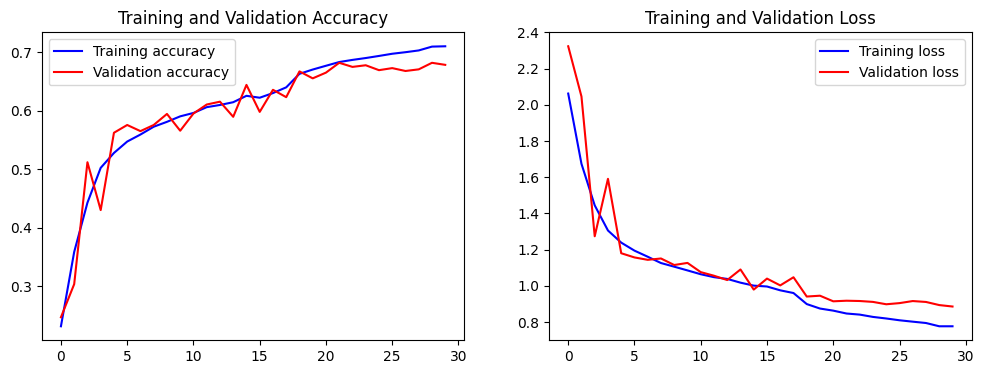

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)


In [22]:
model.save('my_best_model.h5')

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow import keras
best_model = keras.models.load_model('my_best_model.h5')


Y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))


23/23 [==============================] - 3s 111ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       191
     disgust       0.00      0.00      0.00        22
        fear       0.20      0.15      0.17       204
       happy       0.25      0.26      0.25       354
     neutral       0.15      0.17      0.16       246
         sad       0.17      0.18      0.17       249
    surprise       0.12      0.11      0.11       166

    accuracy                           0.18      1432
   macro avg       0.14      0.14      0.14      1432
weighted avg       0.18      0.18      0.17      1432



In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

# Membuat model
model = tf.keras.models.Sequential()

# Block 1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Meningkatkan dropout

# Block 2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Meningkatkan dropout

# Block 3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Meningkatkan dropout

# Block 4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Meningkatkan dropout

# Flattening
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Regularisasi L2
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Meningkatkan dropout

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Regularisasi L2
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Meningkatkan dropout

# Output Layer
model.add(Dense(7, activation='softmax'))

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)       

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/30
359/359 [==============================] - 56s 137ms/step - loss: 6.0434 - accuracy: 0.1912 - val_loss: 3.6125 - val_accuracy: 0.2235 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - 42s 118ms/step - loss: 2.8167 - accuracy: 0.2419 - val_loss: 2.3520 - val_accuracy: 0.2507 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - 41s 115ms/step - loss: 2.0853 - accuracy: 0.2904 - val_loss: 2.1487 - val_accuracy: 0.1899 - lr: 0.0010
Epoch 4/30
359/359 [==============================] - 42s 118ms/step - loss: 1.8530 - accuracy: 0.3592 - val_loss: 2.1555 - val_accuracy: 0.2863 - lr: 0.0010
Epoch 5/30
359/359 [==============================] - 43s 120ms/step - loss: 1.6649 - accuracy: 0.4220 - val_loss: 1.6638 - val_accuracy: 0.4001 - lr: 0.0010
Epoch 6/30
359/359 [==============================] - 44s 123ms/step - loss: 1.5801 - accuracy: 0.4547 - val_loss: 1.5890 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 7/30
359/359 [==============================] 

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow import keras
best_model = keras.models.load_model('my_best_model.h5')


Y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))


23/23 [==============================] - 3s 101ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       191
     disgust       0.06      0.05      0.05        22
        fear       0.10      0.07      0.08       204
       happy       0.25      0.25      0.25       354
     neutral       0.17      0.20      0.19       246
         sad       0.15      0.16      0.15       249
    surprise       0.08      0.08      0.08       166

    accuracy                           0.16      1432
   macro avg       0.13      0.13      0.13      1432
weighted avg       0.16      0.16      0.16      1432



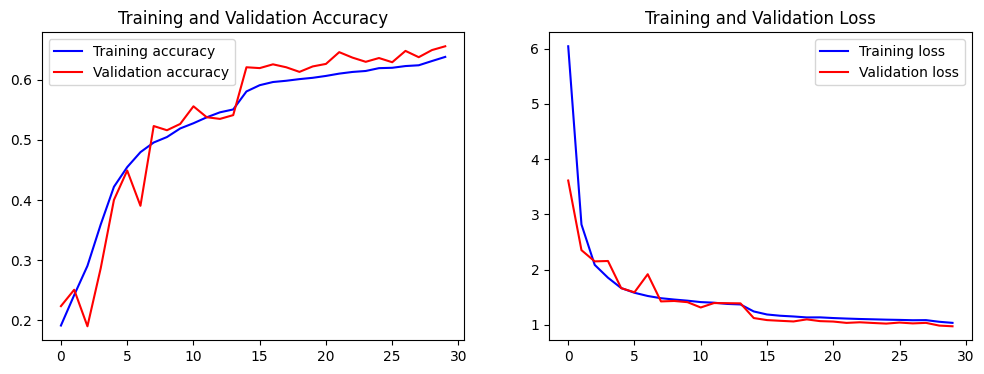

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)


fine Tuning

In [ ]:
!pip install tensorflow transformers datasets


In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import TFViTModel, ViTConfig

# Define parameters
image_size = (48, 48)  # Image size for the generator
batch_size = 64
num_classes = 7

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Generating training and validation data
train_generator = train_datagen.flow_from_directory(
    directory=dataset_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Important for grayscale images
    subset="training",
)

validation_generator = train_datagen.flow_from_directory(
    directory=dataset_test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Important for grayscale images
    subset="validation",
)

# Load the ViT model
vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Set the model to non-trainable initially
vit_model.trainable = False

# Define your input layer
inputs = tf.keras.Input(shape=(48, 48, 1))  # Change to (48, 48, 1) for grayscale

# Prepare the input for ViT
x = tf.image.resize(inputs, (224, 224))  # Resize to (224, 224)
x = tf.keras.layers.Concatenate()([x, x, x])  # Convert grayscale to 3 channels (RGB)
x = vit_model(x)[0] 
x = tf.keras.layers.GlobalAveragePooling1D()(x) 
x = tf.keras.layers.Dense(256, activation='relu')(x)  
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  

# Create the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


ValueError: Exception encountered when calling layer "tf_vi_t_model_9" (type TFViTModel).

in user code:

    File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\transformers\modeling_tf_utils.py", line 763, in run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)
    File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 765, in call  *
        outputs = self.vit(
    File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\haldies\AppData\Local\Temp\__autograph_generated_filelauugpwi.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\haldies\AppData\Local\Temp\__autograph_generated_filesj1tqelq.py", line 24, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(pixel_values=ag__.ld(pixel_values), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "C:\Users\haldies\AppData\Local\Temp\__autograph_generated_filexz_b4sgl.py", line 12, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "C:\Users\haldies\AppData\Local\Temp\__autograph_generated_filexpkuqfyz.py", line 63, in tf__call
        projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)

    ValueError: Exception encountered when calling layer "vit" "                 f"(type TFViTMainLayer).
    
    in user code:
    
        File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\transformers\modeling_tf_utils.py", line 763, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 595, in call  *
            embedding_output = self.embeddings(
        File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\haldies\AppData\Local\Temp\__autograph_generated_filexz_b4sgl.py", line 12, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
        File "C:\Users\haldies\AppData\Local\Temp\__autograph_generated_filexpkuqfyz.py", line 63, in tf__call
            projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
    
        ValueError: Exception encountered when calling layer "embeddings" "                 f"(type TFViTEmbeddings).
        
        in user code:
        
            File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 129, in call  *
                embeddings = self.patch_embeddings(
            File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "C:\Users\haldies\AppData\Local\Temp\__autograph_generated_filexpkuqfyz.py", line 63, in tf__call
                projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
        
            ValueError: Exception encountered when calling layer "patch_embeddings" "                 f"(type TFViTPatchEmbeddings).
            
            in user code:
            
                File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 204, in call  *
                    projection = self.projection(pixel_values)
                File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "c:\Users\haldies\anaconda3\envs\tessss\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
                    raise ValueError(
            
                ValueError: Input 0 of layer "projection" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 224, 3, 224)
            
            
            Call arguments received by layer "patch_embeddings" "                 f"(type TFViTPatchEmbeddings):
              • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
              • interpolate_pos_encoding=None
              • training=False
        
        
        Call arguments received by layer "embeddings" "                 f"(type TFViTEmbeddings):
          • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
          • interpolate_pos_encoding=None
          • training=False
    
    
    Call arguments received by layer "vit" "                 f"(type TFViTMainLayer):
      • self=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • pixel_values=None
      • head_mask=None
      • output_attentions=False
      • output_hidden_states=False
      • interpolate_pos_encoding=None
      • return_dict=True
      • training=False


Call arguments received by layer "tf_vi_t_model_9" (type TFViTModel):
  • self=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • pixel_values=None
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False